In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

#### Create train/test set for accounts and tweets ####

##### Discussion:
The dataset for accounts and tweets are split into train/test ratio of 2/3 and 1/3. In Models_kNN_LDA_QDA_DT_RF notebook we looked at various base models and models using NLP. Here we continue by adding Lexical Diversity Predictors to see if our accuracy improves with all these models. The lexical Diversity features were generated and selected in lexical_diversity NB. These are the additional LD features which we will use to try to improve our model:

| Tweets Features|
|:-------------------|
|LD-uber_index| 
|LD-yule_s_k| 
|LD-mtld| 
|LD-hdd| 

In [103]:
combine_df = []
for file_ in ['../../data/tweets_nlp_1_2_ld.csv','../../data/tweets_nlp_2_2_ld.csv','../../data/tweets_nlp_3_2_ld.csv']:
    df = pd.read_csv(file_,index_col=None, header=0,keep_default_na=False)
    combine_df.append(df)
all_tweets = pd.concat(combine_df, axis = 0, ignore_index = True)  

all_tweets[['LD-yule_s_k']] = all_tweets[['LD-yule_s_k']].fillna(0)

def convert_float(val):
    try:
        return float(val)
    except ValueError:
        return 0

all_tweets['LD-yule_s_k']=all_tweets['LD-yule_s_k'].apply(lambda x: convert_float(x))
train_base_tweets_df, test_base_tweets_df = train_test_split(all_tweets, test_size=0.33, random_state=42, stratify=all_tweets['user_type'])

print('train tweets shape:',train_base_tweets_df.shape)
print('test tweets shape:',test_base_tweets_df.shape)

all_tweets_df = all_tweets[['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions',
                               'user_type', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
                               'ratio_pos', 'ratio_neg', 'ratio_neu', 'token_count', 'url_token_ratio', 'ant',
                               'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust','jaccard','LD-uber_index','LD-yule_s_k','LD-mtld','LD-hdd']]

train_base_tweets_df, test_base_tweets_df = train_test_split(all_tweets_df, test_size=0.33, random_state=42, 
                                                             stratify=all_tweets_df['user_type'])
X_train, y_train = train_base_tweets_df.drop('user_type',axis=1), train_base_tweets_df['user_type']
X_test, y_test = test_base_tweets_df.drop('user_type',axis=1), test_base_tweets_df['user_type']

train tweets shape: (80574, 60)
test tweets shape: (39686, 60)


#### kNN with NLP and Lexical Density features

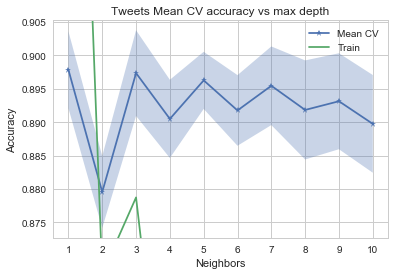

In [74]:
#scale down to 10% or take forever.
Xs_train, Xs_test = scale(X_train), scale(X_test)

neighbors, train_scores, cvmeans, cvstds, cv_scores = [], [], [], [], []
for n in range(1,11):
    neighbors.append(n)
    knn = KNeighborsClassifier(n_neighbors = n)
    train_scores.append(knn.fit(X_train, y_train).score(X_train, y_train))
    scores = cross_val_score(estimator=knn,X=Xs_train, y=y_train, cv=5)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

#Alter data structure for using internal numpy functions
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)
#Plot Means and Shade the +-2 SD Interval
plt.plot(neighbors, cvmeans, '*-', label="Mean CV")
plt.fill_between(neighbors, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(neighbors, train_scores, '-+', label="Train")
plt.ylim(ylim)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Neighbors")
plt.title('Tweets Mean CV accuracy vs max depth')
plt.xticks(neighbors)
plt.show()

#### LDA/QDA with NLP and Lexical Diversity Features

In [32]:
lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
print("LDA score: %f, CV score: %f" % (accuracy_score(y_test, lda.predict(X_test)), cross_val_score(estimator=lda, X=X_test, y=y_test, cv=5).mean()))
print("QDA score: %f, CV score: %f" % (accuracy_score(y_test, qda.predict(X_test)), cross_val_score(estimator=qda, X=X_test, y=y_test, cv=5).mean()))

LDA score: 0.811369, CV score: 0.811873
QDA score: 0.774228, CV score: 0.735321


#### Decision Tree with NLP and Lexical Diversity features

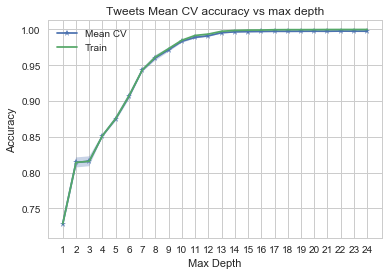

In [33]:
#Perform 5-fold cross validation and store results
depths, train_scores, cvmeans, cvstds, cv_scores = [], [], [], [], []
for depth in range(1,25):
    depths.append(depth)
    dt = DecisionTreeClassifier(max_depth=depth)
    train_scores.append(dt.fit(X_train, y_train).score(X_train, y_train))
    scores = cross_val_score(estimator=dt, X=X_train, y=y_train, cv=5)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

#Alter data structure for using internal numpy functions
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)
#Plot Means and Shade the +-2 SD Interval
plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.ylim(ylim)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.title('Tweets Mean CV accuracy vs max depth')
plt.xticks(depths)
plt.show()

In [34]:
#Choosing the best depth
idx = depths.index(12)
print("Accuracy: Mean={:.3f}, +/- 2 SD: [{:.3f} -- {:.3f}]".format(
    cvmeans[idx], cvmeans[idx] - 2*cvstds[idx], cvmeans[idx] + 2*cvstds[idx]))

Accuracy: Mean=0.991, +/- 2 SD: [0.990 -- 0.993]


In [35]:
#Evaluate performance on Test Set
best_cv_depth = 12
fitted_tree = DecisionTreeClassifier(max_depth=best_cv_depth).fit(X_train, y_train)
best_cv_tree_train_score = fitted_tree.score(X_train, y_train)
best_cv_tree_test_score = fitted_tree.score(X_test, y_test)
print(f"The tree of depth {best_cv_depth} achieved an Accuracy of {best_cv_tree_test_score:.3f} on the test set.")

The tree of depth 12 achieved an Accuracy of 0.993 on the test set.


#### Random Forest with NLP features and LD

In [36]:
#Fit a Random Forest model
fitted_rf = RandomForestClassifier(n_estimators=7, max_depth=13).fit(X_train,y_train)
random_forest_train_score = fitted_rf.score(X_train, y_train)
random_forest_test_score = fitted_rf.score(X_test, y_test)
print(f"The Random Forest scored {random_forest_train_score:.3f} on the training set.")
print(f"The Random Forest scored {random_forest_test_score:.3f} on the test set.")

The Random Forest scored 0.985 on the training set.
The Random Forest scored 0.982 on the test set.


#### Neural Network without NLP

In this section we try to use Keras to build a layered Neural Net.
We will use a fully-connected network structure with five layers.

Fully connected layers are defined using the Dense class.

We will use the sigmoid activation function on the first layer,softmax activation in the next, rectifier (‘relu‘) activation function on the next two layers and the sigmoid function in the output layer. We use a sigmoid on the output layer to ensure our network output is between 0 and 1 and easy to map to either a probability of class 1 or snap to a hard classification of either class.

We can piece it all together by adding each layer. The first layer has 100 neurons and expects 5 input variables. The second hidden layer has 300 neurons, the third has 100 and the fourth has 50 neurons,respectively.Finally, the output layer has 1 neuron to predict the class (bot or not).

In [104]:
all_tweets_df = all_tweets[['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions','user_type']].sample(frac=.30)
train_base_tweets_df, test_base_tweets_df = train_test_split(all_tweets_df, test_size=0.33, random_state=42, stratify=all_tweets_df['user_type'])

X_train, y_train = train_base_tweets_df.drop('user_type',axis=1), train_base_tweets_df['user_type']
X_test, y_test = test_base_tweets_df.drop('user_type',axis=1), test_base_tweets_df['user_type']

model = Sequential([
    Dense(100, input_shape=(5,), activation='sigmoid'),
    Dense(300, activation='softmax'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 100)               600       
_________________________________________________________________
dense_50 (Dense)             (None, 300)               30300     
_________________________________________________________________
dense_51 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_52 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 51        
Total params: 66,101
Trainable params: 66,101
Non-trainable params: 0
_________________________________________________________________


In [106]:
history=model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split = .2)

Train on 19337 samples, validate on 4835 samples
Epoch 1/100
19337/19337 [==============================] - 2s 93us/step - loss: 0.4319 - acc: 0.7911 - val_loss: 0.4292 - val_acc: 0.7963
Epoch 2/100
19337/19337 [==============================] - 2s 101us/step - loss: 0.4321 - acc: 0.7922 - val_loss: 0.4289 - val_acc: 0.7961
Epoch 3/100
19337/19337 [==============================] - 2s 82us/step - loss: 0.4315 - acc: 0.7912 - val_loss: 0.4294 - val_acc: 0.7950
Epoch 4/100
19337/19337 [==============================] - 2s 99us/step - loss: 0.4312 - acc: 0.7903 - val_loss: 0.4279 - val_acc: 0.7948
Epoch 5/100
19337/19337 [==============================] - 2s 83us/step - loss: 0.4305 - acc: 0.7910 - val_loss: 0.4318 - val_acc: 0.7950
Epoch 6/100
19337/19337 [==============================] - 2s 83us/step - loss: 0.4303 - acc: 0.7903 - val_loss: 0.4255 - val_acc: 0.7961
Epoch 7/100
19337/19337 [==============================] - 2s 96us/step - loss: 0.4302 - acc: 0.7913 - val_loss: 0.4265 - 

In [107]:
NN_testScore=model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], NN_testScore[1]*100))

11906/11906 [==============================] - 0s 25us/step

acc: 79.79%


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


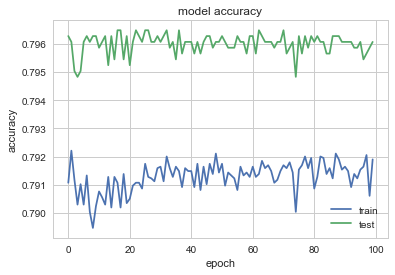

In [108]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

#### Lexical Diversity + NLP +  Neural Network

Next we use a similar model but by adding in the NLP and Lexical Diversity features to see if we get an improvement in accuracy.

In [142]:
all_tweets_df_ld = all_tweets[['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions',
                               'user_type', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
                               'ratio_pos', 'ratio_neg', 'ratio_neu', 'ant',
                               'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust','jaccard','LD-uber_index','LD-yule_s_k','LD-mtld','LD-hdd']]

train_base_tweets_df, test_base_tweets_df = train_test_split(all_tweets_df_ld, test_size=0.33, random_state=42, stratify=all_tweets_df_ld['user_type'])

X_train, y_train = train_base_tweets_df.drop('user_type',axis=1), train_base_tweets_df['user_type']
X_test, y_test = test_base_tweets_df.drop('user_type',axis=1), test_base_tweets_df['user_type']

model = Sequential([
    Dense(50, input_shape=(23,), activation='sigmoid'),
    Dense(200, activation='tanh'),
    Dense(300, activation='softmax'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [153]:
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split = .2)



Train on 64459 samples, validate on 16115 samples
Epoch 1/100
64459/64459 [==============================] - 7s 106us/step - loss: 0.0697 - acc: 0.9715 - val_loss: 0.2764 - val_acc: 0.9378
Epoch 2/100
64459/64459 [==============================] - 6s 98us/step - loss: 0.0702 - acc: 0.9722 - val_loss: 0.2950 - val_acc: 0.9296
Epoch 3/100
64459/64459 [==============================] - 7s 101us/step - loss: 0.0694 - acc: 0.9731 - val_loss: 0.2760 - val_acc: 0.9391
Epoch 4/100
64459/64459 [==============================] - 7s 104us/step - loss: 0.0640 - acc: 0.9750 - val_loss: 0.3441 - val_acc: 0.9199
Epoch 5/100
64459/64459 [==============================] - 7s 106us/step - loss: 0.0666 - acc: 0.9742 - val_loss: 0.2737 - val_acc: 0.9355
Epoch 6/100
64459/64459 [==============================] - 7s 106us/step - loss: 0.0620 - acc: 0.9751 - val_loss: 0.2730 - val_acc: 0.9391
Epoch 7/100
64459/64459 [==============================] - 7s 106us/step - loss: 0.0674 - acc: 0.9729 - val_loss: 0.2

In [155]:
NN_testScore_ld=model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model_nlp.metrics_names[1], NN_testScore_ld[1]*100))

39686/39686 [==============================] - 1s 36us/step

acc: 93.89%


In [ ]:
print(model.evaluate(X_test, y_test))

model_json = model.to_json()

with open("model_ld_"+".json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model_ld_"+".h5")

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
plt.savefig("model_ld_"+".jpg")